# Task 3

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# ensembles.py

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed


def root_mean_squared_error(y_true, y_pred):
    if len(y_pred.shape) == 1:
        y_pred = y_pred[np.newaxis, :]
    return np.sqrt(np.mean((y_pred - y_true) ** 2, axis=1))


class RandomForestMSE:
    def __init__(self, n_estimators, max_depth=None, feature_subsample_size=None,
                 base_estimator=DecisionTreeRegressor, **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.base_estimator = base_estimator
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        if self.feature_subsample_size is None:
            self.feature_subsample_size = np.ceil(X.shape[1] / 3).astype(np.int_)

        self.estimators = Parallel(n_jobs=-1)(delayed(self._task)(X, y)
                                              for _ in range(self.n_estimators))
        train_loss = []
        test_loss = []

        y_pred = 0
        y_pred_val = 0
        for i, estimator in enumerate(self.estimators):
            y_pred += estimator.predict(X)
            train_loss.append(root_mean_squared_error(y, y_pred / (i + 1)))
            if X_val is not None:
                y_pred_val += estimator.predict(X_val)
                test_loss.append(root_mean_squared_error(y_val, y_pred_val / (i + 1)))
        return self, train_loss, test_loss

    def _task(self, X, y):
        estimator = self.base_estimator(max_depth=self.max_depth,
                                        max_features=self.feature_subsample_size,
                                        **self.trees_parameters)
        idxs = np.random.randint(X.shape[0], size=X.shape[0])
        return estimator.fit(X[idxs], y[idxs])

    def predict(self, X, all=False):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        if all:
            predictions = np.zeros((self.n_estimators, X.shape[0]))
        prediction = np.zeros(X.shape[0])
        for i, estimator in enumerate(self.estimators):
            prediction += estimator.predict(X)
            if all:
                predictions[i] = prediction / (i + 1)
        if all:
            return predictions
        return prediction / self.n_estimators


class GradientBoostingMSE:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
                 base_estimator=DecisionTreeRegressor, **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use learning_rate * gamma instead of gamma
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.base_estimator = base_estimator
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        self.estimators = []
        self.coefs = []
        train_loss = []
        test_loss = []
        y_pred = np.zeros(X.shape[0])
        if X_val is not None:
            y_pred_val = np.zeros(X_val.shape[0])
        if self.feature_subsample_size is None:
            self.feature_subsample_size = np.ceil(X.shape[1] / 3).astype(np.int_)
        for _ in range(self.n_estimators):
            estimator = self.base_estimator(max_depth=self.max_depth,
                                            max_features=self.feature_subsample_size,
                                            **self.trees_parameters)
            self.estimators.append(estimator.fit(X, 2 * (y - y_pred) / X.shape[0]))
            prediction = self.estimators[-1].predict(X)
            self.coefs.append(minimize_scalar(lambda x, y=y, h=y_pred, b=prediction:
                                              ((y - h - x * b) ** 2).mean()).x)
            y_pred += self.learning_rate * self.coefs[-1] * prediction
            train_loss.append(root_mean_squared_error(y, y_pred))
            if X_val is not None:
                y_pred_val += self.learning_rate * self.coefs[-1] * self.estimators[-1].predict(X_val) 
                test_loss.append(root_mean_squared_error(y_val, y_pred_val))
        return self, train_loss, test_loss

    def predict(self, X, all=False):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        if all:
            predictions = np.zeros((self.n_estimators, X.shape[0]))
        prediction = np.zeros(X.shape[0])
        for i in range(len(self.estimators)):
            prediction += self.coefs[i] * self.estimators[i].predict(X)
            if all:
                predictions[i] = prediction
        if all:
            return self.learning_rate * predictions
        return self.learning_rate * prediction


In [3]:
def plot_results(train_loss, test_loss, path=None):
    fig = plt.figure(figsize=(20, 10))

    x = np.arange(len(train_loss))
    plt.plot(x, train_loss, label='Train', c='royalblue', linewidth=3, alpha=0.8)
    if len(test_loss) > 0:
        plt.plot(x, test_loss, label='Test', c='crimson', linewidth=3, alpha=0.8)

    plt.xlabel('Iteration', fontsize=17)
    plt.ylabel('RMSE',  fontsize=17)
    plt.title('RMSE to Iteration',  fontsize=25)
    plt.legend(fontsize=13)
    plt.grid(True)
    
    if path is not None:
        plt.savefig(path)
    
    if len(test_loss) > 0:
        best_iter = np.argmin(test_loss)
        return test_loss[best_iter], train_loss[best_iter], best_iter
    best_iter = np.argmin(train_loss)
    return train_loss[best_iter], best_iter


## Light Test

In [4]:
X, y = load_boston(True)

C:\Users\miracle\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass return_X_y=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=317)

In [6]:
model, train_loss, test_loss = RandomForestMSE(10000, 30).fit(X_train, y_train, X_test, y_test)

(array([3.12990644]), array([1.28004506]), 150)

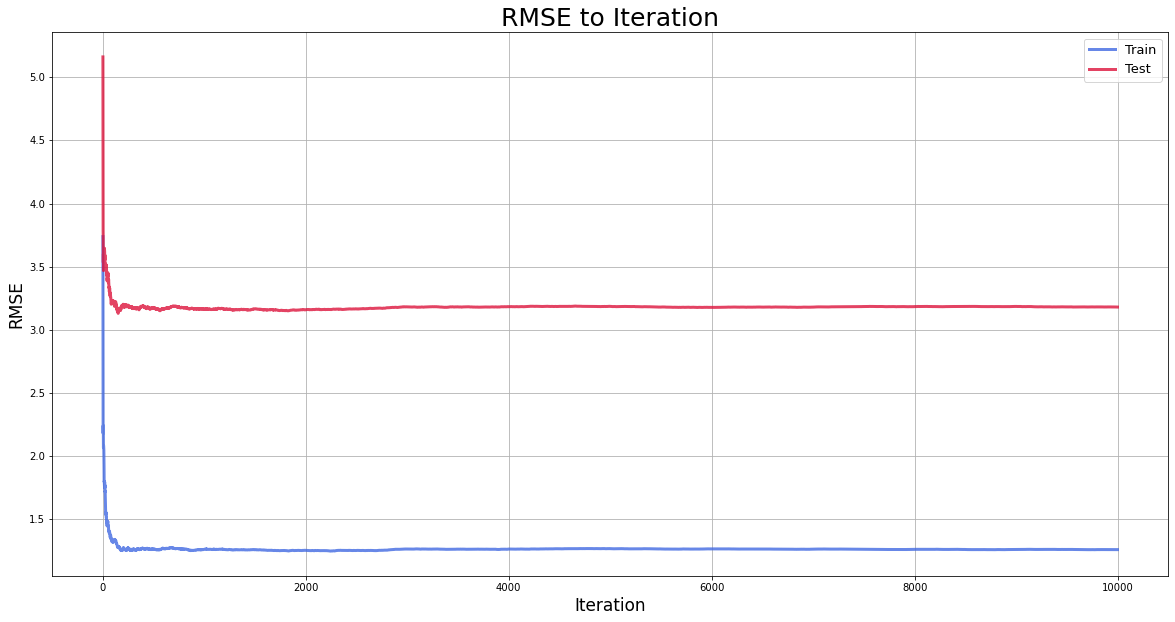

In [7]:
plot_results(train_loss, test_loss)

In [8]:
model, train_loss, test_loss = GradientBoostingMSE(10000, max_depth=6).fit(X_train, y_train, X_test, y_test)

(array([3.07401413]), array([0.13848805]), 106)

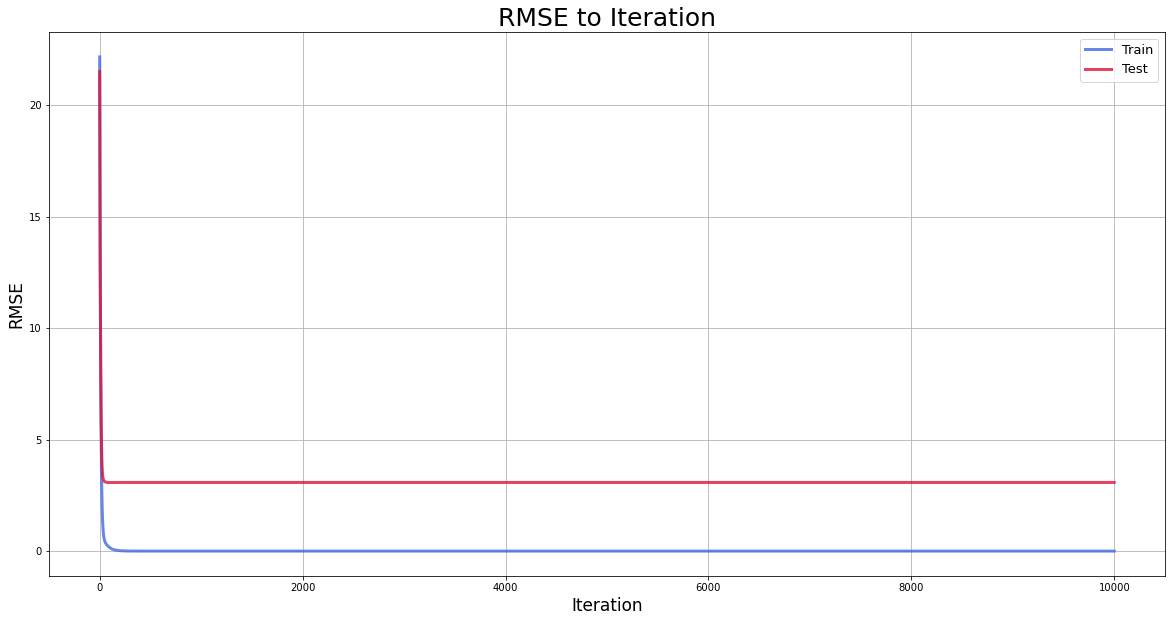

In [9]:
plot_results(train_loss, test_loss)

In [10]:
train_loss[-1], test_loss[-1]

(array([1.25299485e-14]), array([3.07865089]))

Check:

In [11]:
tmp = GradientBoostingMSE(1000)
_, train_loss, test_loss = tmp.fit(X_train, y_train, X_test, y_test)

In [12]:
root_mean_squared_error(y_test, tmp.predict(X_test))

array([3.03729236])

In [13]:
test_loss[-1]

array([3.03729236])

##  Main Part

In [14]:
df = pd.read_csv('train_data.csv')
df.drop(['index', 'id'], axis=1, inplace=True)
df.date = pd.to_datetime(df.date).apply(lambda x:
                                        (x - pd.Timestamp(2010, 1, 1)).days)
new_features = pd.get_dummies(df.bedrooms_number)
df[new_features.columns] = new_features
df.drop('bedrooms_number', axis=1, inplace=True)

In [15]:
df

,date,batchrooms_number,square_footage_home,square_footage_lot,floors_number,has_waterfront,has_been_viewed,condition_quality,housing_unity_grade,square_footage_except_basement,...,3,4,5,6,7,8,9,10,11,33
0,1582,2.00,1350,2560,1.0,0,0,3,8,1350,...,0,0,0,0,0,0,0,0,0,0
1,1582,1.75,1800,23103,1.0,0,0,3,7,1800,...,1,0,0,0,0,0,0,0,0,0
2,1582,1.75,2240,10578,2.0,0,0,5,8,1550,...,1,0,0,0,0,0,0,0,0,0
3,1582,2.00,1820,5000,1.5,0,1,3,7,1640,...,0,1,0,0,0,0,0,0,0,0
4,1582,1.75,1560,8700,1.0,0,0,4,7,1560,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,1894,2.50,1921,4888,2.0,0,0,3,7,1921,...,0,1,0,0,0,0,0,0,0,0
17276,1894,2.50,1890,11036,1.0,0,0,3,8,1460,...,1,0,0,0,0,0,0,0,0,0
17277,1894,1.00,1380,10112,1.0,0,0,4,7,940,...,1,0,0,0,0,0,0,0,0,0
17278,1894,1.00,960,5000,1.0,0,0,3,6,960,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X = df.values
y = pd.read_csv('train_target.csv').price.values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=317)

In [18]:
X_train.shape[0], X_test.shape[0]

(12096, 5184)

### RF

#### n_estimators

In [24]:
for n_estimators in [10, 100, 300, 500, 800, 1000, 2500]:
    start_time = time()
    print(n_estimators, '&', np.round(root_mean_squared_error(y_test,
                                                     RandomForestMSE(n_estimators,
                                                                     max_depth=22,
                                                                     feature_subsample_size=0.7).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

10 & 127.4665 & 3.837 \\ \hline
100 & 119.2506 & 3.917 \\ \hline
300 & 118.9167 & 12.211 \\ \hline
500 & 118.1341 & 19.736 \\ \hline
800 & 118.0323 & 32.271 \\ \hline
1000 & 117.8181 & 39.685 \\ \hline
2500 & 118.1271 & 98.544 \\ \hline


In [25]:
_, train_loss, test_loss = RandomForestMSE(n_estimators=2500,
                                           max_depth=22,
                                           feature_subsample_size=0.7).fit(X_train, y_train, X_test, y_test)

(array([118.33255359]), array([49.24225681]), 1676)

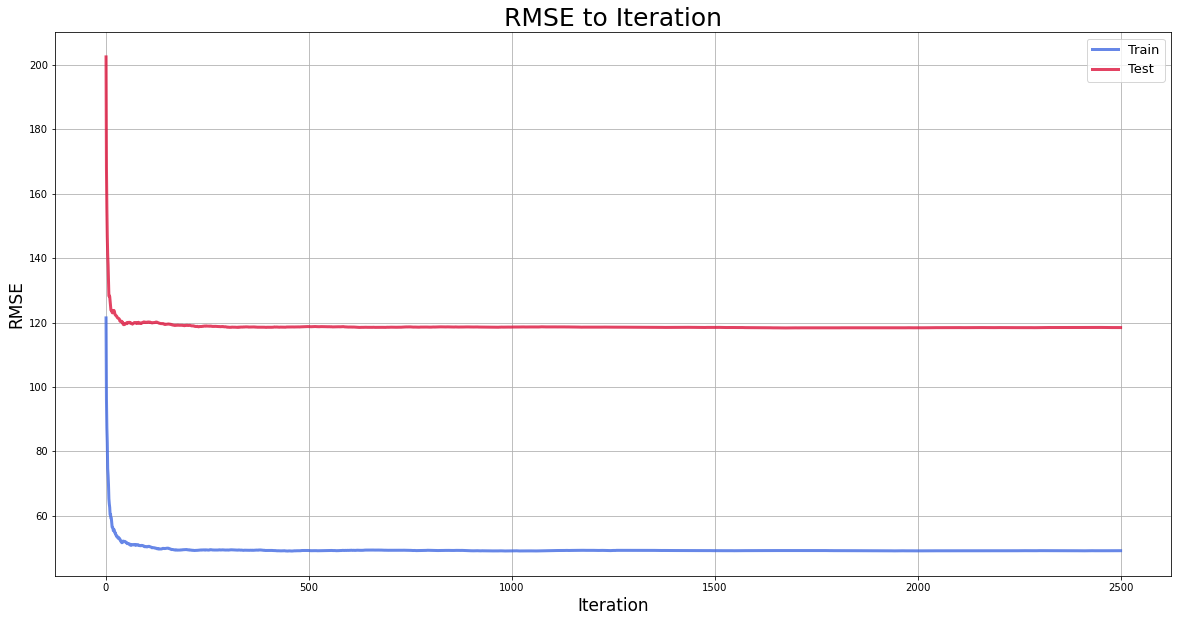

In [26]:
plot_results(train_loss, test_loss, 'rf_plot.png')

#### dimension

In [27]:
for feature_subsample_size in [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]:
    start_time = time()
    print(feature_subsample_size, '&', np.round(root_mean_squared_error(y_test,
                                                          RandomForestMSE(n_estimators=1000,
                                                                          max_depth=22,
                                                                          feature_subsample_size=feature_subsample_size).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

0.1 & 138.6692 & 18.465 \\ \hline
0.3 & 122.7939 & 24.906 \\ \hline
0.5 & 118.9703 & 32.127 \\ \hline
0.7 & 118.7364 & 38.966 \\ \hline
0.8 & 118.298 & 43.305 \\ \hline
0.9 & 118.1342 & 46.988 \\ \hline
1 & 154.0329 & 15.142 \\ \hline


#### depth

In [28]:
for max_depth in [3, 5, 9, 15, 22, 27, 32, 40, 50, None]:
    start_time = time()
    print(max_depth, '&', np.round(root_mean_squared_error(y_test,
                                             RandomForestMSE(n_estimators=1000,
                                                             max_depth=max_depth,
                                                             feature_subsample_size=0.7).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

3 & 197.2342 & 12.114 \\ \hline
5 & 160.297 & 15.795 \\ \hline
9 & 128.6512 & 21.223 \\ \hline
15 & 118.837 & 32.874 \\ \hline
22 & 118.4231 & 38.725 \\ \hline
27 & 118.3923 & 39.691 \\ \hline
32 & 117.8966 & 40.679 \\ \hline
40 & 118.4197 & 42.233 \\ \hline
50 & 118.2913 & 43.173 \\ \hline
None & 118.0025 & 43.905 \\ \hline


### GBDT

#### n_estimators

In [30]:
for n_estimators in [10, 100, 300, 500, 800, 1000, 2500]:
    start_time = time()
    print(n_estimators, '&', np.round(root_mean_squared_error(y_test, GradientBoostingMSE(n_estimators,
                                                                            max_depth=6,
                                                                            feature_subsample_size=0.7,
                                                                            learning_rate=0.1).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

10 & 265.5242 & 0.607 \\ \hline
100 & 112.8786 & 6.327 \\ \hline
300 & 112.0387 & 17.743 \\ \hline
500 & 110.6598 & 28.611 \\ \hline
800 & 112.3461 & 43.275 \\ \hline
1000 & 111.4958 & 50.626 \\ \hline
2500 & 111.66 & 123.285 \\ \hline


In [31]:
_, train_loss, test_loss = GradientBoostingMSE(n_estimators=2500,
                                               max_depth=6,
                                               feature_subsample_size=0.7,
                                               learning_rate=0.1).fit(X_train, y_train, X_test, y_test)

(array([108.17715421]), array([29.05285768]), 625)

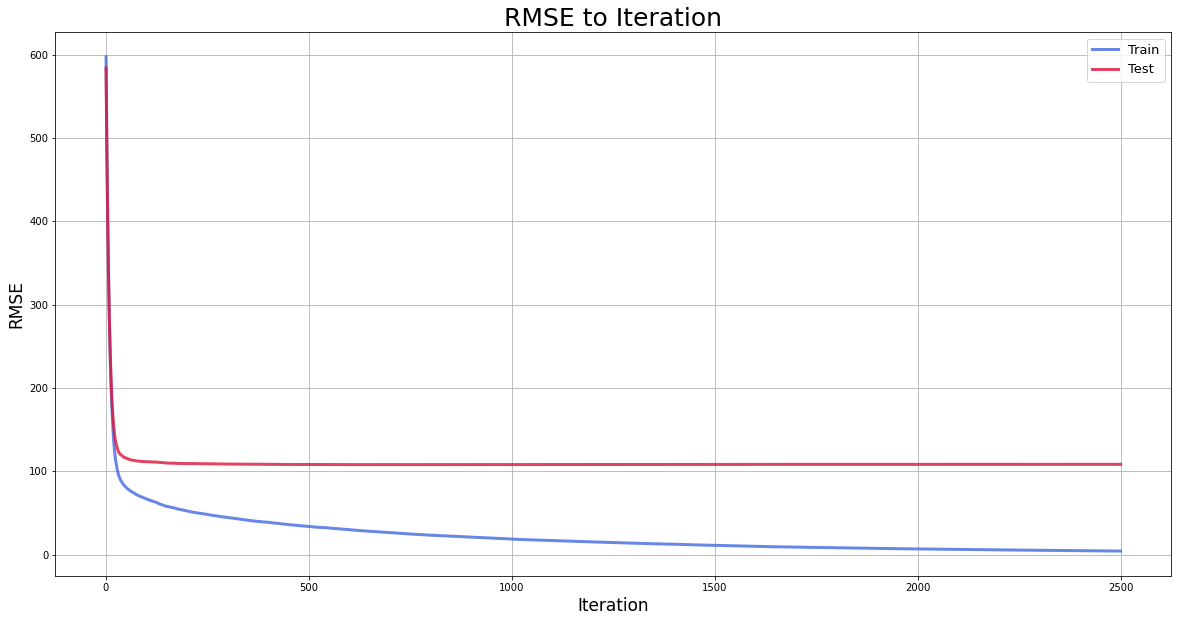

In [32]:
plot_results(train_loss, test_loss, 'gb_plot.png')

#### dimension

In [33]:
for feature_subsample_size in [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]:
    start_time = time()
    print(feature_subsample_size, '&', np.round(root_mean_squared_error(y_test,
                                                          GradientBoostingMSE(n_estimators=1000,
                                                                              max_depth=6,
                                                                              feature_subsample_size=feature_subsample_size,
                                                                              learning_rate=0.1).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

0.1 & 122.6883 & 14.745 \\ \hline
0.3 & 108.8641 & 24.897 \\ \hline
0.5 & 110.7159 & 35.6 \\ \hline
0.7 & 109.8719 & 47.492 \\ \hline
0.8 & 110.8404 & 52.486 \\ \hline
0.9 & 110.6577 & 58.807 \\ \hline
1 & 128.2873 & 9.73 \\ \hline


#### depth

In [34]:
for max_depth in [3, 5, 9, 15, 22, 27, 32, 40, 50, None]:
    start_time = time()
    print(max_depth, '&', np.round(root_mean_squared_error(y_test,
                                             GradientBoostingMSE(n_estimators=1000,
                                                                 max_depth=max_depth,
                                                                 feature_subsample_size=0.7,
                                                                 learning_rate=0.1).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

3 & 110.7048 & 28.193 \\ \hline
5 & 108.8505 & 40.94 \\ \hline
9 & 115.7349 & 68.817 \\ \hline
15 & 121.3925 & 106.287 \\ \hline
22 & 123.2503 & 125.441 \\ \hline
27 & 123.0779 & 125.589 \\ \hline
32 & 123.7637 & 126.333 \\ \hline
40 & 122.4359 & 124.326 \\ \hline
50 & 123.1098 & 119.9 \\ \hline
None & 123.5908 & 122.479 \\ \hline


#### learning rate

In [36]:
for lr in [0.001, 0.01, 0.05, 0.1, 0.5, 1]:
    start_time = time()
    print(lr, '&', np.round(root_mean_squared_error(y_test,
                                      GradientBoostingMSE(n_estimators=1000,
                                                          max_depth=6,
                                                          feature_subsample_size=0.7,
                                                          learning_rate=lr).fit(X_train, y_train)[0].predict(X_test))[0], 4),
          '&', np.round(time() - start_time, 3), '\\\\ \hline')

0.001 & 275.9895 & 46.942 \\ \hline
0.01 & 111.6654 & 49.603 \\ \hline
0.05 & 109.4831 & 50.18 \\ \hline
0.1 & 111.1591 & 50.582 \\ \hline
0.5 & 129.2203 & 49.699 \\ \hline
1 & 177.6525 & 48.862 \\ \hline
